# Hyperparameter Tuning Tutorial

Machine learning models often have many hyperparameters that need to be tuned to achieve maximal performance (e.g: learning rate, dropout rate, number of layers, layer size, etc) . This motivates the need for hyperparameter tuners that intelligently search the space of hyperparameters for a high performing model. 

To address this, MeTaL supports multiple hyperparameter tuners with an easy-to-use interface that allows users to streamline the hyperparameter optimization process. This tutorial covers utilizing MeTaL's hyperparameter tuners to tune an EndModel for maximal performance. Currently, two hyperparameter algorithms are supported:

- <b>Random Search</b>
- <b>Hyperband</b>

The tutorial is broken down into the following sections 

1. <b>Set up the Problem and Load the Data</b>
2. <b>Define the Search Space</b>
3. <b>Run Random Search</b>
4. <b>Run Hyperband Search</b>
5. <b>Compare Random Search against Hyperband Search</b>

Let's begin!

## Setup
Before beginning, we first need to make sure that the metal/ directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed snorkel-metal with pip or conda (or that you've added the repo to your path if you're running from source; for example, running source add_to_path.sh from the repository root).

In [1]:
import matplotlib
%load_ext autoreload
%autoreload 2
%matplotlib inline
import metal

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set up the Problem and Load the Data

First let's set up our problem and load our data. For the purposes of this tutorial (and to keep the search process short) we will use the small model introduced in the basic tutorial. 

In [2]:
# Load basic tutorial data
from metal.utils import split_data
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)
    
Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

Let's define and train our label model like in the basic tutorial.

In [20]:
# Train a the label model
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

label_model.train_model(Ls[0], Y_dev=Ys[1], n_epochs=500, log_train_every=100, lr=0.01, l2=1e-1)
score = label_model.score((Ls[1], Ys[1]))
scores = label_model.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])

from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score((Ls[1], Ys[1]), metric=['accuracy', 'precision', 'recall', 'f1'])
Y_train_probs = label_model.predict_proba(Ls[0])

Computing O...
Estimating \mu...
[100 epo]: TRAIN:[loss=0.030]
[200 epo]: TRAIN:[loss=0.029]
[300 epo]: TRAIN:[loss=0.029]
[400 epo]: TRAIN:[loss=0.029]
[500 epo]: TRAIN:[loss=0.029]
Finished Training
Accuracy: 0.881
        y=1    y=2   
 l=1    183    63    
 l=2    56     698   
Accuracy: 0.881
Precision: 0.766
Recall: 0.744
F1: 0.755
        y=1    y=2   
 l=1    183    63    
 l=2    56     698   
Accuracy: 0.836
Precision: 0.623
Recall: 0.841
F1: 0.716
        y=1    y=2   
 l=1    207    39    
 l=2    125    629   


Now let's define our EndModel and verify that it successfully runs and achieves a decent score. 

In [21]:
# Train an end model
from metal.end_model import EndModel

end_model_basic = EndModel([1000,2], 
                           train_config={
                               "n_epochs": 5,
                               "l2" : 0.01,
                               "validation_metric":'f1',
                               "data_loader_config" : {
                                   "batch_size" : 256
                               }
                           }, seed=123)

end_model_basic.train_model((Xs[0], Y_train_probs), valid_data=(Xs[1], Ys[1]))



Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Linear(in_features=1000, out_features=2, bias=True)
)

[1 epo]: TRAIN:[loss=0.493] VALID:[accuracy=0.978]
Saving model at iteration 1 with best score 0.978
[2 epo]: TRAIN:[loss=0.466] VALID:[accuracy=0.959]
[3 epo]: TRAIN:[loss=0.464] VALID:[accuracy=0.956]
[4 epo]: TRAIN:[loss=0.465] VALID:[accuracy=0.984]
Saving model at iteration 4 with best score 0.984
[5 epo]: TRAIN:[loss=0.465] VALID:[accuracy=0.959]
Restoring best model from iteration 4 with score 0.984
Finished Training
F1: 0.967
        y=1    y=2   
 l=1    231    15    
 l=2     1     753   


Great. Notice that our F1 is around .953. In the sections below we will try to optimize the hyperparameters of this EndModel to achieve an even higher score!

## Define the Search Space

Before starting the hyperparameter tuning process, we need to specify the space of the hyperparameters we're searching. 

For the purposes of this tutorial we search over the following hyperparameters:
- <b>n_epochs</b>: Integer representing the number of epochs to train
- <b>batchnorm</b>: Boolean representing whether to use batch-normalization
- <b>lr</b>: Float representing the learning rate for optimization
- <b>layer_out_dims</b>: The architecture of our neural network

In [5]:
search_space = {
    'n_epochs': [1, 5, 10],
    'batchnorm' : [True, False],
    'dropout': [0, .1, .2, .3, .4, .5],
    'lr': {'range': [1e-5, 1], 'scale': 'log'},
    'layer_out_dims' : [[1000,10,2], [1000, 100, 2]],
    'seed': [123]
}

Here's a breakdown of what each line in the configuration means:

- `'n_epochs': [1, 5, 10],`: This specifies that the hyperparameter tuner may train the model for either 1, 5 or 10 epochs
- `'batchnorm' : [True, False],`: This specifies that a model instantiated by the tuner may have batchnorm as either True or False
- `dropout': [0, .1, .2, .3, .4, .5]`: Like the above, this specifies that the dropout parameter of an instantiated model may be one of 0, .1, .2, .3, .4, or .5
- `'lr': {'range': [1e-5, 1], 'scale': 'log'}`: This specifies that the learning rate of the training of a model may range from 1e-5 to 1, and that the tuner samples the learning rate on a log scale
- `'layer_out_dims' : [[1000,10,2], [1000, 100, 2]]`: This specifies that upon instantiation of the model, the structure of the fully connected network can either be [1000, 10, 2] or [1000, 100, 2]; in the latter case, this means the network takes a 1000 dimensional input, has a hidden layer with 100 features and an output layer with 2 classes
- `seed': [123]`,: This specifies that each end model should be initialized with the same random seed (for repeatability)

Now that our search space is defined, let's start optimizing hyperparameters!

## Run Random Search

While simple, random search has proven to be a powerful and efficient algorithm for tuning hyperparameters (see http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf for why). Let's use the RandomSearch tuner to find a good set of hyperparameters for our EndModel. Note that although we only do hyperparameter optimization for the EndModel, the tuners may also be used to do hyperparameter optimization for LabelModels.

To start, let's import the RandomSearchTuner and instantiate our RandomSearchTuner to optimize an EndModel model.

In [6]:
from metal.tuners.random_tuner import RandomSearchTuner
rs_tuner = RandomSearchTuner(EndModel, seed=123, validation_metric="f1")

Next let's define our training and validation datasets.

In [7]:
train_args = [(Xs[0], Y_train_probs)]
X_dev, Y_dev = Xs[1], Ys[1]

And just like that we're prepped to launch our random search! Performing the search is just as easy and requires just a single call to the `search` function.

Most of the arguments to the `search` function below are self explanatory, but there are a couple of key arguments to watch out for:
- `max_search` : This specifies the number of configurations to search over. As it is set to 20 below, this means we search over 20 random models and return the best one
- `verbose`: This specifies whether the tuner should be verbose or not and can be used to turn on/off the its logging feature

In [8]:
best_rs_model = rs_tuner.search(search_space, (X_dev, Y_dev), train_args=train_args, max_search=20, verbose=False, seed=123)
rs_tuner.best_score

0.9729729729729729

Our best random search model achieves an F1 of ~.975 which outperforms the model we had previously (F1 ~ .953). Can we do even better than random search by either attaining the same accuracy faster or achieving a higher score? The following section walks through using the <b>Hyperband</b> tuner, which recent research has shown to be more efficient than random search.

## Run Hyperband Search

While random search performs surprisingly well, we can be more efficient if we adaptively allocate more compute resources for configurations that perform well than to those that don't. For example if a configuration seems to yield a really poor model after the first epoch of training, it's unlikely it'll perform well even after more training, so we can early-terminate the training of this configuration to save compute. This is the core idea behind the <b>Hyperband</b> algorithm which recent research has shown to outperform various algorithms including random search. (See https://arxiv.org/abs/1603.06560 if interested!)

Running Hyperband is just as easy as running random search. Let's import the HyperbandTuner and instantiate it. 

Note that there is one extra argument to initialize the HyperbandTuner:
- `hyperband_epochs_budget`: This specifies the number of total epochs of training the tuner can perform in its search for a performant model. This is used to create the Hyperband search schedule.

In [9]:
from metal.tuners.hyperband_tuner import HyperbandTuner
hb_tuner = HyperbandTuner(EndModel, hyperband_epochs_budget=150, seed=123, validation_metric="f1")

|           Hyperband Schedule          |
Table consists of tuples of (num configs, num_resources_per_config) which specify how many configs to run and for how many epochs. 
Each bracket starts with a list of random configurations which is successively halved according the schedule.
See the Hyperband paper (https://arxiv.org/pdf/1603.06560.pdf) for more details.
-----------------------------------------
Bracket 0: (9, 2) (3, 6) (1, 19)
Bracket 1: (3, 6) (1, 19)
Bracket 2: (3, 19)
-----------------------------------------


We can launch the Hyperband search process using the same `search` call. Note that since the Hyperband schedule already limits the amount of compute we do, we don't have to set the `max_search` argument; the algorithm will attempt to make best use of the computed we've allocated!

In [10]:
best_hb_model = hb_tuner.search(search_space, (X_dev, Y_dev), train_args=train_args, verbose=False, seed=123)
hb_tuner.best_score

[SUMMARY]
Best model: [0_3]
Best config: {'n_epochs': 19, 'batchnorm': True, 'dropout': 0.2, 'layer_out_dims': [1000, 100, 2], 'seed': 123, 'lr': 0.0004837052086066461}
Best score: 0.9643605870020965


0.9643605870020965

We achieve F1 ~.987, which beat our initial score of F1 ~.95 and essentially matches the score achieved by random search (F1 ~.975). The next section will compare the performances of random search and Hyperband using the logged data.

## Compare Random Search against Hyperband Search

During `search`, MeTaL hyperparameter tuners track useful statistics. Currently these include
* Time elapsed
* Achieved score
* Configuration for score

We will analyze these statistics to compare random search against Hyperband. 

Let's take a look at a few of the collected datapoints as a `pandas` dataframe.

In [11]:
hb_tuner.run_stats_df()[:3]

,batchnorm,dropout,layer_out_dims,lr,n_epochs,score,seed
0,False,0.0,"[1000, 10, 2]",0.370024,2,0.000000,123
1,False,0.1,"[1000, 100, 2]",0.019515,2,0.889888,123
2,False,0.4,"[1000, 100, 2]",0.000071,2,0.845070,123


Now, let's extract the raw statistics captured by our tuners.

In [12]:
hb_stats = hb_tuner.run_stats
rs_stats = rs_tuner.run_stats

The `run_stats` property is a list of datapoints, where each datapoint (captured by a dictionary) specifies the current elapsed timestamp, the score achieved for that timestamp and the hyperparameter configuration for the score.

Let's extract the best score achieved per timestamp.

In [13]:
def gather_best_scores_from_stats(stats):    
    res = []
    best_score = float("-inf")
    for stat in stats:
        best_score = max(best_score, stat["score"])
        time_elapsed = stat["time_elapsed"]
        res.append({"best_score" : best_score, "time_elapsed" : time_elapsed})
    return res

hb_best_score_stats = gather_best_scores_from_stats(hb_stats)
rs_best_score_stats = gather_best_scores_from_stats(rs_stats)

Now that we have our score data, let's compare the performances of random search and hyperband by plotting the best scores they achieve across time!

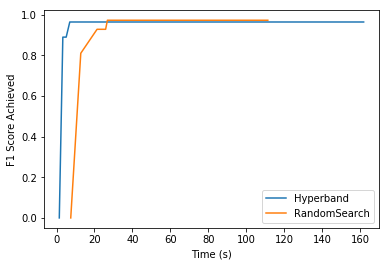

In [14]:
import matplotlib.pyplot as plt

def plot_score_vs_time(rs_data, hb_data, logscale=False):
    plt.cla()
    
    if logscale:
        plt.xscale("log")
    
    xs_hyperband = [x["time_elapsed"] for x in hb_data]
    ys_hyperband = [x["best_score"] for x in hb_data]
    xs_rs = [x["time_elapsed"] for x in rs_data]
    ys_rs = [x["best_score"] for x in rs_data]
    
    plt.plot(xs_hyperband, ys_hyperband, label="Hyperband")
    plt.plot(xs_rs, ys_rs, label="RandomSearch")
    
    plt.xlabel("Time (s)")
    plt.ylabel("F1 Score Achieved")
        
    plt.legend(loc="best")
    
plot_score_vs_time(rs_best_score_stats, hb_best_score_stats)

Interesting! Our plot shows that Hyperband finds a good solution faster than random search. 

From the plot above, we see that Hyperband finds its best solution at around time 10s, whereas it takes random search around 50-75s to achieve a comparable score.  The relative performance of these algorithms does depend on the specific problem at hand, but the qualitative trends observed here should transfer to many applications in practice.  

And that wraps up the hyperparameter tuning tutorial! We hope that MeTaL's hyperparameter tuners are useful for your applications and make hyperparameter tuning enjoyable. Happy tuning!